### Dataset Link: [Twenty Newsgroups Dataset](http://archive.ics.uci.edu/dataset/113/twenty+newsgroups)

In [17]:
import os
import re
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [18]:
stopWords = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him",
    "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as",
    "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
    "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then",
    "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some",
    "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
]


In [19]:
def load_data_from_folders(folder_path):
    x = []
    y = []

    for collection in os.listdir(folder_path):

        # Use os.path.join for cleaner and safer paths
        class_path = os.path.join(folder_path, collection)

        if not os.path.isdir(class_path):
            continue

        for document in os.listdir(class_path):
            doc_path = os.path.join(class_path, document)

            try:
                with open(doc_path, "r", encoding="latin1") as f:
                    x.append((document, f.read()))
                    y.append(collection)
            except Exception as e:
                print(f"Could not read file {doc_path}: {e}")


    return x, y


In [20]:
x, y = load_data_from_folders("./20_newsgroups/")


In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [22]:
def create_vocabulary(x):
    vocab = defaultdict(int)

    for _, text in x:
        word_arr = re.split(r'\W+', text)

        for word in word_arr:
            word = word.lower()

            if len(word) <= 2 or word in stopWords or not word.isalpha():
                continue

            vocab[word] += 1

    return vocab


In [23]:
vocab = create_vocabulary(x_train)

vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)


In [24]:
x_axis, y_axis = [], []

for i in range(len(vocab)):
    x_axis.append(i)
    y_axis.append(vocab[i][1])


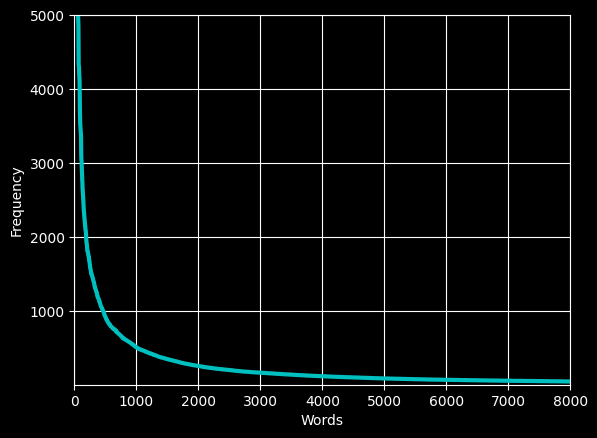

In [25]:
import matplotlib.pyplot as plt

plt.plot(x_axis, y_axis, "-c", linewidth=3)
plt.axis([0, 8000, 1, 5000])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [26]:
vocab_words = [word[0] for word in vocab[:3000]]


In [27]:
def create_dataset(x):
    dataset = np.zeros([len(x), len(vocab_words)], dtype=int)

    word_to_idx = {word: idx for idx, word in enumerate(vocab_words)}

    for i in range(len(x)):
        word_arr = re.split(r'\W+', x[i][1])

        for word in word_arr:
            word = word.lower()

            if len(word) <= 2 or word in stopWords or not word.isalpha():
                continue

            idx = word_to_idx.get(word)
            if idx is not None:
                dataset[i][idx] += 1

    return dataset


In [28]:
x_train_dataset = create_dataset(x_train)
x_test_dataset = create_dataset(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)


In [29]:
clf = MultinomialNB()

clf.fit(x_train_dataset, y_train)

y_pred = clf.predict(x_test_dataset)

print("Train Score:", clf.score(x_train_dataset, y_train))
print("Test Score:", clf.score(x_test_dataset, y_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Train Score: 0.9017940863911984
Test Score: 0.8655
Accuracy: 0.8655


In [30]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns


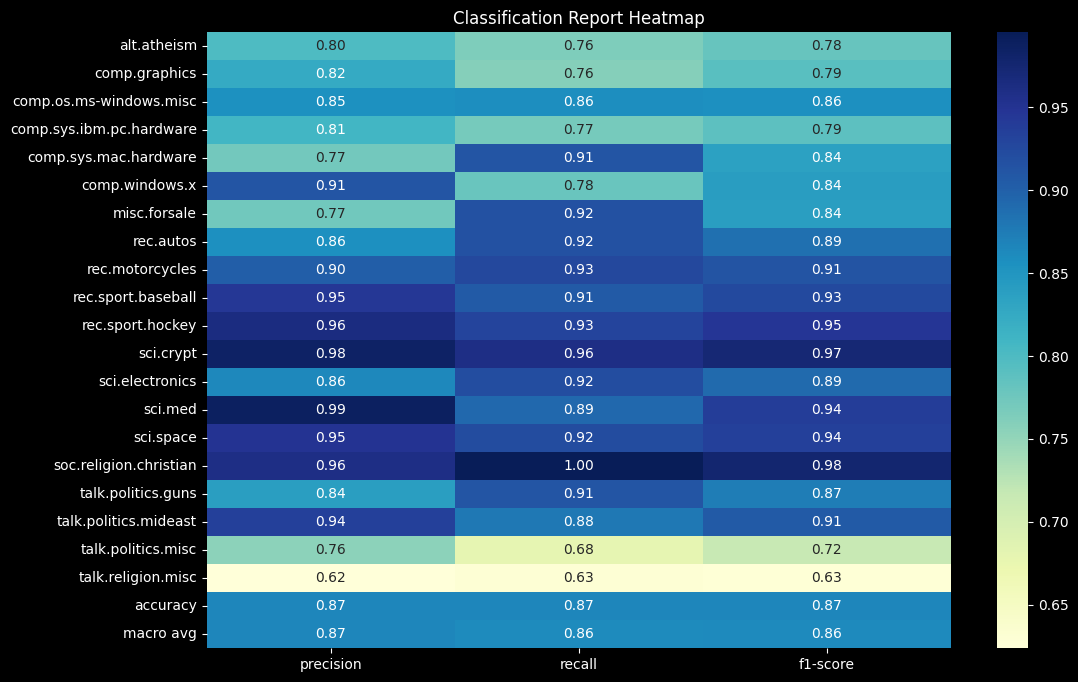

In [31]:
# Get classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()


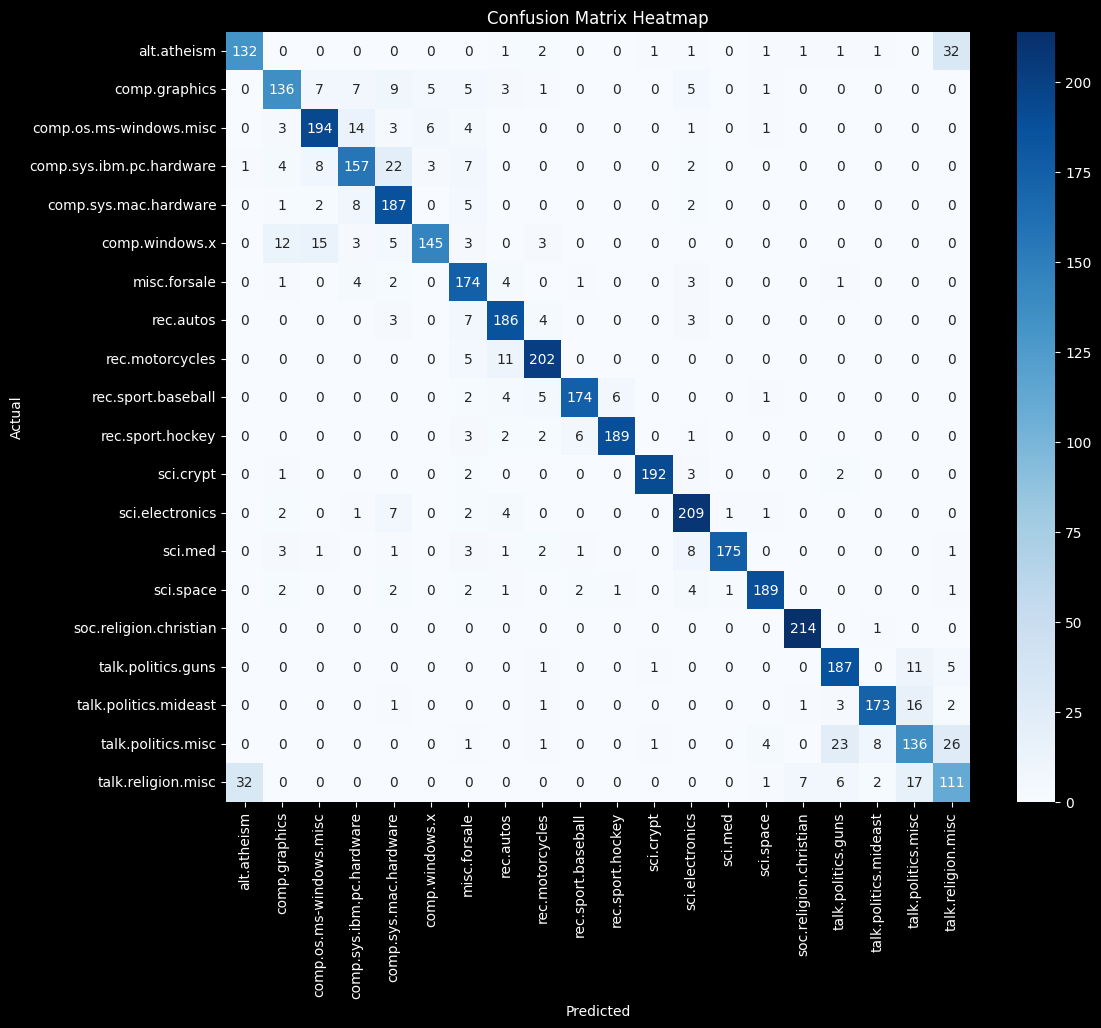

In [32]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [33]:
def fit(x, y):
    summary = defaultdict(dict)

    for curr_class in set(y):
        curr_class_docs = x[y == curr_class]
        word_counts = np.sum(curr_class_docs, axis=0)  # Sum over all documents

        total_words = np.sum(word_counts)  # Total words in this class

        for i, word in enumerate(vocab_words):
            summary[curr_class][word] = (word_counts[i] + 1) / (total_words + len(vocab_words))  # Laplace smoothing

        summary[curr_class]['total'] = total_words  # Save total words, not docs

    summary['total'] = len(x)  # Total documents overall

    return summary


In [34]:
def probability(summary, curr_class, document):
    prob = np.log(summary[curr_class]['total']) - np.log(summary['total'])  # Prior

    for i, word in enumerate(vocab_words):
        word_prob = summary[curr_class].get(word, 1e-9)  # Directly use stored probability
        prob += document[i] * np.log(word_prob)

    return prob


In [35]:

def predict_single(summary, document):
    best_class = None
    best_probability = -np.inf  # Initialize with a very low value for log probabilities

    for curr_class in summary.keys():
        if curr_class == 'total':
            continue

        prob = probability(summary, curr_class, document)

        if prob > best_probability:
            best_class = curr_class
            best_probability = prob

    return best_class


In [36]:
def predict(summary, x):
    y = []

    for document in x:
        y.append(predict_single(summary, document))

    return y


In [37]:
def score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [38]:
summary = fit(x_train_dataset, y_train)
y_pred = predict(summary, x_test_dataset)

print(f"Accuracy: {score(y_test, y_pred)}")

Accuracy: 0.866


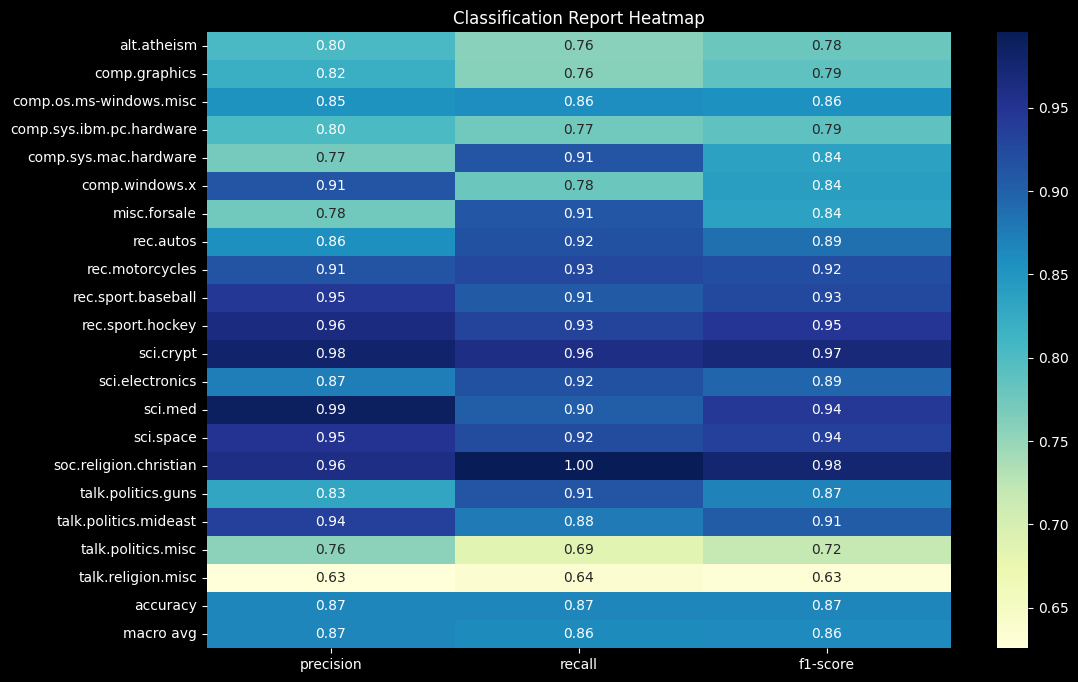

In [43]:
# Get classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()


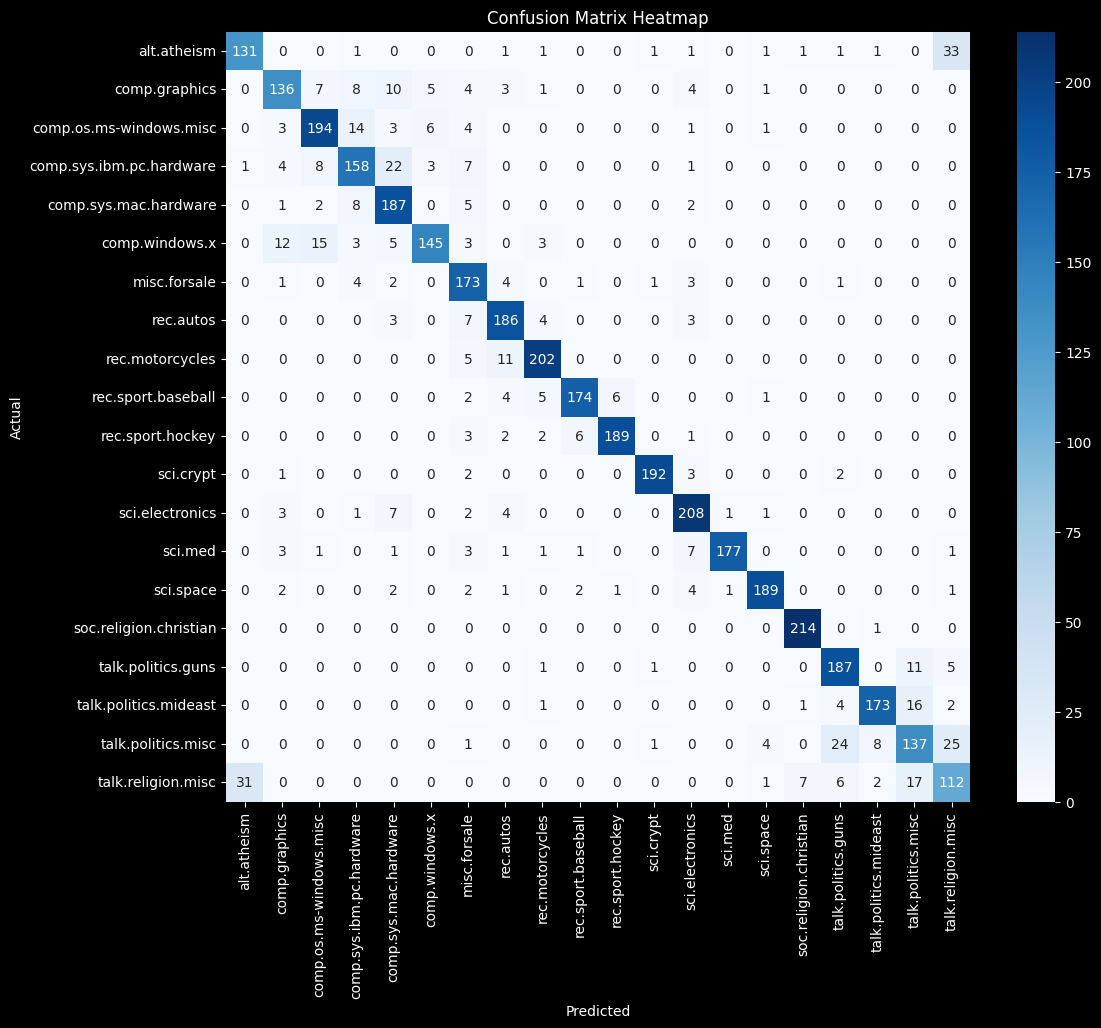

In [42]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()
